In [1]:
import pandas as pd
import numpy as np
# import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from datetime import datetime
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='default')
prod_list = dict({'GPM':
                    {
                        'org_scale':'30min',
                        'unit':'mm/hr',
                        'tscales':['30min', 'H', 'D'],
                        'scale_f': 1,
                        'dt_col':'dt',
                        'p_col':'precip',
                        'p_thres':0.5,
                        'fn': '/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/GPM/csv_half_hourly/gpm_turkey.csv'
                    }
                }) 
# ASOS: Rain gauge-based precip data from Automated Surface Observing System --- GPM: Global Precipitation Mission
# HH: Half-hourly (GPM), H: Hourly (ASOS and GPM), D: Daily (ASOS & GPM)
_data = dict()
for key in prod_list:
    prod = prod_list[key]
    dt_col = prod['dt_col']
    p_col = prod['p_col']
    _data[key] = pd.read_csv(prod['fn'])
    _data[key]['timestamps'] = pd.to_datetime(_data[key][dt_col])
    idx = _data[key][p_col] < prod['p_thres']
    _data[key].loc[idx, p_col] = 0
    _data[key]['rain'] = _data[key][p_col] * prod['scale_f']
p_data = dict()
for key in prod_list:
    prod = prod_list[key]
    dt_col = prod['dt_col']
    p_col = prod['p_col']
    p_data[key] = dict()
    for tscale in prod['tscales']:
        x = _data[key].set_index('timestamps')
        if (key == 'GPM') & (tscale =='D'):
            p_data[key][tscale] = x['rain'].resample(tscale).sum()/2
        elif (key == 'GPM') & (tscale =='H'):
            p_data[key][tscale] = x['rain'].resample(tscale).sum()/2
        elif (key == 'ASOS') & (tscale =='H'):
            p_data[key][tscale] = x['rain'].resample(tscale).mean()
        elif (key == 'ASOS') & (tscale =='D'):
            print('test')
            p_data[key][tscale] = x['rain'].resample(tscale).sum()
        else:
            p_data[key][tscale] = x['rain'].resample(tscale).sum()
        p_data[key][tscale] = p_data[key][tscale].reset_index()

In [19]:
from functions.check_model import sm_model_time_based,sm_model
run_sets = dict()
run_sets[1] = dict()
run_sets[2] = dict()
run_sets[3] = dict()
run_sets[1]['et_p'] = 3.1
run_sets[1]['theta_i'] = 246
run_sets[1]['theta_wp'] = 74
run_sets[1]['theta_star'] = 143.1 # Field Capacity
run_sets[1]['theta_s'] = 246
run_sets[1]['yaron_c'] = 0.022
run_sets[1]['color'] = 'blue'


run_sets[2]['et_p'] = 6.3
run_sets[2]['theta_i'] = 574
run_sets[2]['theta_wp'] = 173
run_sets[2]['theta_star'] = 330 # Field Capacity
run_sets[2]['theta_s'] = 574
run_sets[2]['yaron_c'] = 0.022
run_sets[2]['color'] = 'red'

run_sets[3]['et_p'] = 4.6
run_sets[3]['theta_i'] = 574
run_sets[3]['theta_wp'] = 173
run_sets[3]['theta_star'] = 330 # Field Capacity
run_sets[3]['theta_s'] = 574
run_sets[3]['yaron_c'] = 0.014
run_sets[3]['color'] = 'green'

results = dict()
div_fac = {'30min':24*2, 'H':24, 'D':1}
div_fac1 = {'30min':24, 'H':24, 'D':1}
for tscale in prod_list['GPM']['tscales']:
    results[tscale] = dict()
    data_forcing = []

    for i, p in enumerate(p_data['GPM'][tscale]['rain']):
        if p>0:
            data_forcing.append((i, 1, p*div_fac[tscale], p_data['GPM'][tscale]['timestamps'].loc[i]))
            # data_forcing.append((i, 1, p, p_data['GPM'][tscale]['timestamps'].loc[i]))
        else:
            data_forcing.append((i, 0, 0, p_data['GPM'][tscale]['timestamps'].loc[i]))
    for i in range(1,4):
        results[tscale][i] = dict()
        et_p = run_sets[i]['et_p']
        theta_i = run_sets[i]['theta_i']
        theta_wp = run_sets[i]['theta_wp']
        theta_star = run_sets[i]['theta_star']
        theta_s = run_sets[i]['theta_s']
        yaron_c = run_sets[i]['yaron_c']
        
        results[tscale][i]['res_p'], results[tscale][i]['data_p'] = sm_model_time_based(data_forcing, theta_i, theta_s, theta_wp, theta_star, et_p/div_fac[tscale], yaron_c, tscale)
        # results[tscale][i]['res_p'], results[tscale][i]['data_p'] = sm_model(data_forcing, theta_i, theta_s, theta_wp, theta_star, et_p, yaron_c)

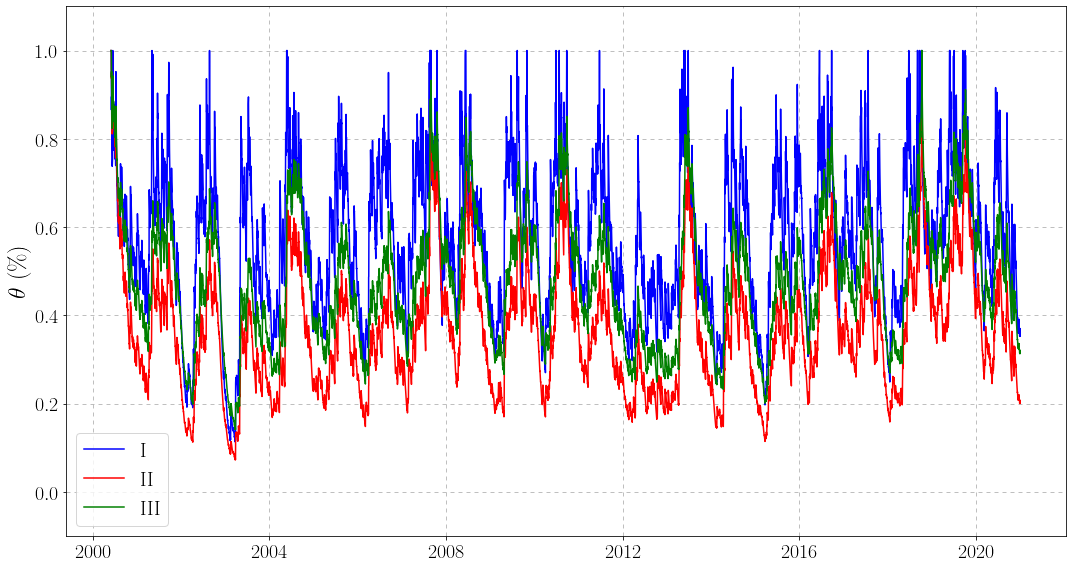

In [28]:
# xlimits = [(0,)]
fig,ax = plt.subplots(figsize=(15, 8))
# ax1 = ax.twinx()
# ax1.plot(precip_data['dt'], precip_data['precipitationCal'], color='blue', alpha=0.5)
tscale = 'D'
# res_p, data_p = sm_model(data, theta_i, theta_s, theta_star, et_p, yaron_c)
for i in range(1,4):
    ax.plot(results[tscale][i]['res_p'][:,3], (results[tscale][i]['res_p'][:,1]/run_sets[i]['theta_s']), color=run_sets[i]['color'], label=i*'I')
    # ax.annotate(i*'I', xy=(results_et[i]['res_p'][-30, 0] , results_et[i]['res_p'][-30, 1]/run_sets[i]['theta_s'] ),xytext=(results_et[i]['res_p'][-20, 0], results_et[i]['res_p'][-18, 1]/run_sets[i]['theta_s']+0.1*results_et[i]['res_p'][-10, 1]/run_sets[i]['theta_s']),transform=ax.transAxes,
    #         fontsize=20,rotation=-10 )

ax.set_ylim([-.1,1.1])
# xlimits = [0, 70]
# ax.set_xlim([datetime(2015,1,1), datetime(2016, 12,31)])
# ax1.set_xlim(xlimits)
# ax.set_ylim([0,.4])
plt.grid(True, which='major', axis='both', linestyle = (0, (5, 5)))
ax.tick_params(labelsize = 20)
# ax1.tick_params(labelsize = 20)
ax.set_ylabel(r'$\theta$ (\%)', fontsize = 24)
# ax1.set_ylabel(r'P (mm)', fontsize = 24)
# ax.set_xlabel(r'Time (days)', fontsize = 24)
ax.legend(fontsize=20)
fig.tight_layout()
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/model_sm_daily_all_years.jpg', dpi=300)

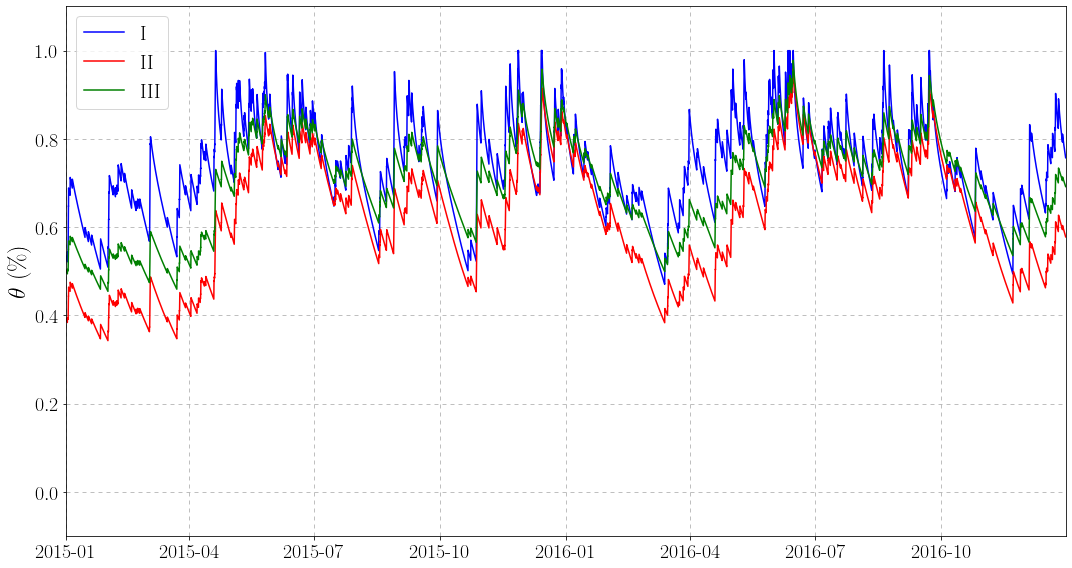

In [24]:
import matplotlib
from datetime import datetime
# load the xfrac package
# matplotlib.rcParams["text.latex.preamble"] = r'\usepackage[dvips]{graphicx}\usepackage{xfrac}'

# xlimits = [(0,)]
fig,ax = plt.subplots(figsize=(15, 8))
# ax1 = ax.twinx()
# ax1.plot(precip_data['dt'], precip_data['precipitationCal'], color='blue', alpha=0.5)
tscale = 'H'
# res_p, data_p = sm_model(data, theta_i, theta_s, theta_star, et_p, yaron_c)
for i in range(1,4):
    ax.plot(results[tscale][i]['res_p'][:,3], (results[tscale][i]['res_p'][:,1]/run_sets[i]['theta_s']), color=run_sets[i]['color'], label=i*'I')
    # ax.annotate(i*'I', xy=(results_et[i]['res_p'][-30, 0] , results_et[i]['res_p'][-30, 1]/run_sets[i]['theta_s'] ),xytext=(results_et[i]['res_p'][-20, 0], results_et[i]['res_p'][-18, 1]/run_sets[i]['theta_s']+0.1*results_et[i]['res_p'][-10, 1]/run_sets[i]['theta_s']),transform=ax.transAxes,
    #         fontsize=20,rotation=-10 )

ax.set_ylim([-.1,1.1])
# xlimits = [0, 70]
ax.set_xlim([datetime(2015,1,1), datetime(2016, 12,31)])
# ax1.set_xlim(xlimits)
# ax.set_ylim([0,.4])
plt.grid(True, which='major', axis='both', linestyle = (0, (5, 5)))
ax.tick_params(labelsize = 20)
# ax1.tick_params(labelsize = 20)
ax.set_ylabel(r'$\theta$ (\%)', fontsize = 24)
# ax1.set_ylabel(r'P (mm)', fontsize = 24)
# ax.set_xlabel(r'Time (days)', fontsize = 24)
ax.legend(fontsize=20)
fig.tight_layout()
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/model_sm_hourly_2015_2016.jpg', dpi=300)

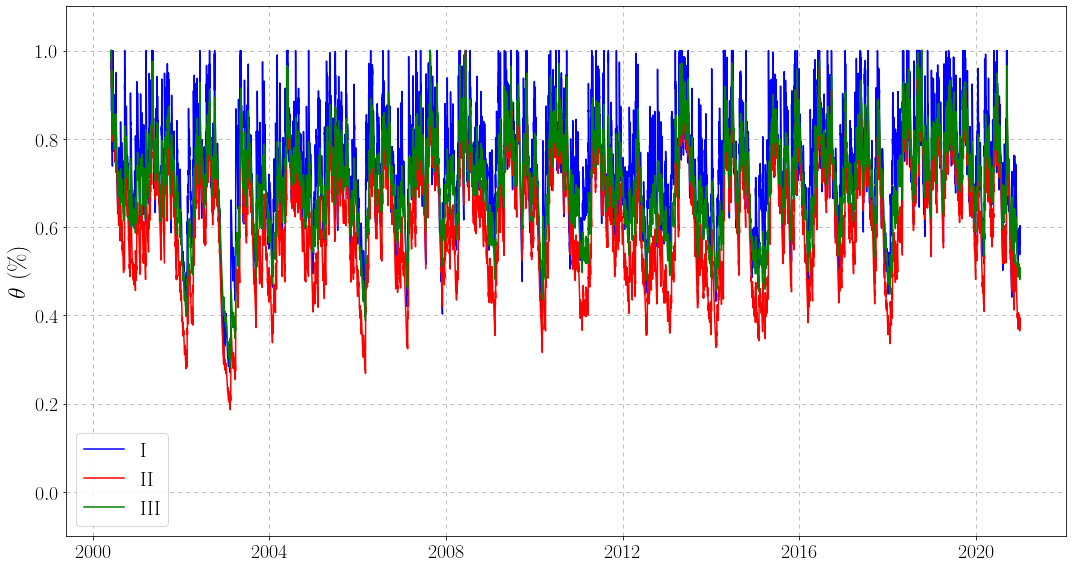

In [23]:
import matplotlib
from datetime import datetime
# load the xfrac package
# matplotlib.rcParams["text.latex.preamble"] = r'\usepackage[dvips]{graphicx}\usepackage{xfrac}'

# xlimits = [(0,)]
fig,ax = plt.subplots(figsize=(15, 8))
# ax1 = ax.twinx()
# ax1.plot(precip_data['dt'], precip_data['precipitationCal'], color='blue', alpha=0.5)
tscale = 'H'
# res_p, data_p = sm_model(data, theta_i, theta_s, theta_star, et_p, yaron_c)
for i in range(1,4):
    ax.plot(results[tscale][i]['res_p'][:,3], (results[tscale][i]['res_p'][:,1]/run_sets[i]['theta_s']), color=run_sets[i]['color'], label=i*'I')
    # ax.annotate(i*'I', xy=(results_et[i]['res_p'][-30, 0] , results_et[i]['res_p'][-30, 1]/run_sets[i]['theta_s'] ),xytext=(results_et[i]['res_p'][-20, 0], results_et[i]['res_p'][-18, 1]/run_sets[i]['theta_s']+0.1*results_et[i]['res_p'][-10, 1]/run_sets[i]['theta_s']),transform=ax.transAxes,
    #         fontsize=20,rotation=-10 )

ax.set_ylim([-.1,1.1])
# xlimits = [0, 70]
# ax.set_xlim([datetime(2015,1,1), datetime(2016, 12,31)])
# ax1.set_xlim(xlimits)
# ax.set_ylim([0,.4])
plt.grid(True, which='major', axis='both', linestyle = (0, (5, 5)))
ax.tick_params(labelsize = 20)
# ax1.tick_params(labelsize = 20)
ax.set_ylabel(r'$\theta$ (\%)', fontsize = 24)
# ax1.set_ylabel(r'P (mm)', fontsize = 24)
# ax.set_xlabel(r'Time (days)', fontsize = 24)
ax.legend(fontsize=20)
fig.tight_layout()
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/model_sm_hourly_all_years.jpg', dpi=300)

In [10]:
from functions.check_model import sm_model_time_based,sm_model
run_sets = dict()
run_sets[1] = dict()
run_sets[2] = dict()
run_sets[3] = dict()
run_sets[1]['et_p'] = 3.1
run_sets[1]['theta_i'] = 246
run_sets[1]['theta_wp'] = 74
run_sets[1]['theta_star'] = 143.1 # Field Capacity
run_sets[1]['theta_s'] = 246
run_sets[1]['yaron_c'] = 0.022
run_sets[1]['color'] = 'blue'


run_sets[2]['et_p'] = 6.3
run_sets[2]['theta_i'] = 574
run_sets[2]['theta_wp'] = 173
run_sets[2]['theta_star'] = 330 # Field Capacity
run_sets[2]['theta_s'] = 574
run_sets[2]['yaron_c'] = 0.022
run_sets[2]['color'] = 'red'

run_sets[3]['et_p'] = 4.6
run_sets[3]['theta_i'] = 574
run_sets[3]['theta_wp'] = 173
run_sets[3]['theta_star'] = 330 # Field Capacity
run_sets[3]['theta_s'] = 574
run_sets[3]['yaron_c'] = 0.014
run_sets[3]['color'] = 'green'

data_forcing = [(i, 0, 0, 0) for i in range(1,10000)]
results = dict()
div_fac = {'30min':24*2, 'H':24, 'D':1}
div_fac1 = {'30min':24, 'H':24, 'D':1}
for tscale in prod_list['GPM']['tscales']:
    results[tscale] = dict()
    # data_forcing = []

    # for i, p in enumerate(p_data['GPM'][tscale]['rain']):
    # for i, p in enumerate(data):
    #     if p>0:
    #         data_forcing.append((i, 1, p*div_fac[tscale], p_data['GPM'][tscale]['timestamps'].loc[i]))
    #         data_forcing.append((i, 1, data*div_fac[tscale], p_data['GPM'][tscale]['timestamps'].loc[i]))
    #         # data_forcing.append((i, 1, p, p_data['GPM'][tscale]['timestamps'].loc[i]))
    #     else:
    #         data_forcing.append((i, 0, 0, p_data['GPM'][tscale]['timestamps'].loc[i]))
    for i in range(1,4):
        results[tscale][i] = dict()
        et_p = run_sets[i]['et_p']
        theta_i = run_sets[i]['theta_i']
        theta_wp = run_sets[i]['theta_wp']
        theta_star = run_sets[i]['theta_star']
        theta_s = run_sets[i]['theta_s']
        yaron_c = run_sets[i]['yaron_c']
        
        results[tscale][i]['res_p'], results[tscale][i]['data_p'] = sm_model_time_based(data_forcing, theta_i, theta_s, theta_wp, theta_star, et_p/div_fac[tscale], yaron_c, tscale)
        # results[tscale][i]['res_p'], results[tscale][i]['data_p'] = sm_model(data_forcing, theta_i, theta_s, theta_wp, theta_star, et_p, yaron_c)

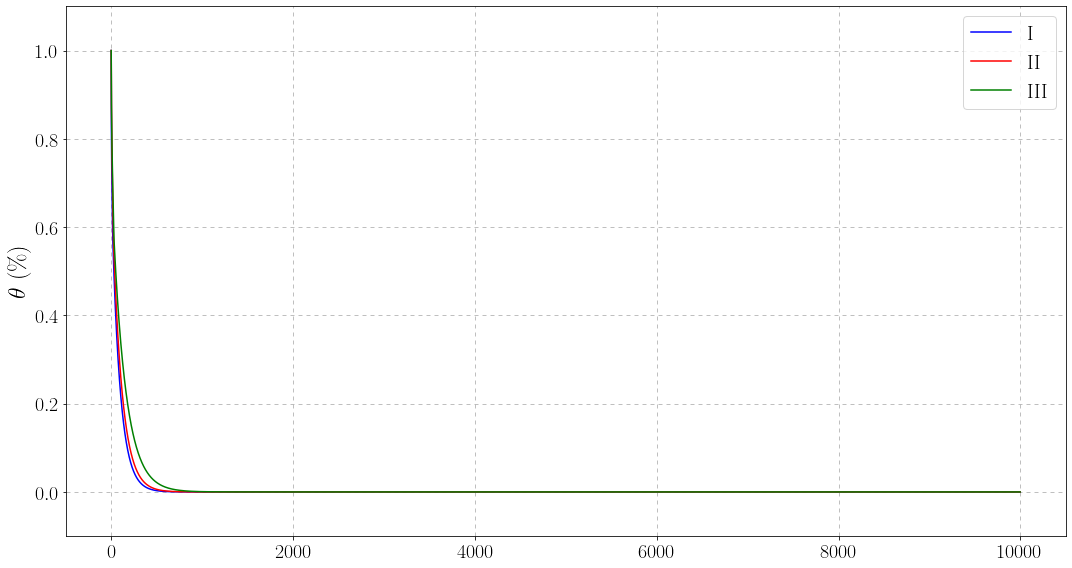

In [13]:
import matplotlib
from datetime import datetime
# load the xfrac package
# matplotlib.rcParams["text.latex.preamble"] = r'\usepackage[dvips]{graphicx}\usepackage{xfrac}'

# xlimits = [(0,)]
fig,ax = plt.subplots(figsize=(15, 8))
# ax1 = ax.twinx()
# ax1.plot(precip_data['dt'], precip_data['precipitationCal'], color='blue', alpha=0.5)
tscale = 'D'
# res_p, data_p = sm_model(data, theta_i, theta_s, theta_star, et_p, yaron_c)
for i in range(1,4):
    ax.plot( (results[tscale][i]['res_p'][:,1]/run_sets[i]['theta_s']), color=run_sets[i]['color'], label=i*'I')
    # ax.annotate(i*'I', xy=(results_et[i]['res_p'][-30, 0] , results_et[i]['res_p'][-30, 1]/run_sets[i]['theta_s'] ),xytext=(results_et[i]['res_p'][-20, 0], results_et[i]['res_p'][-18, 1]/run_sets[i]['theta_s']+0.1*results_et[i]['res_p'][-10, 1]/run_sets[i]['theta_s']),transform=ax.transAxes,
    #         fontsize=20,rotation=-10 )

ax.set_ylim([-.1,1.1])
# xlimits = [0, 70]
# ax.set_xlim([datetime(2015,1,1), datetime(2016, 12,31)])
# ax1.set_xlim(xlimits)
# ax.set_ylim([0,.4])
plt.grid(True, which='major', axis='both', linestyle = (0, (5, 5)))
ax.tick_params(labelsize = 20)
# ax1.tick_params(labelsize = 20)
ax.set_ylabel(r'$\theta$ (\%)', fontsize = 24)
# ax1.set_ylabel(r'P (mm)', fontsize = 24)
# ax.set_xlabel(r'Time (days)', fontsize = 24)
ax.legend(fontsize=20)
fig.tight_layout()
# fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/model_sm_dry_downs_ts.jpg', dpi=300)

Text(0, 0.5, '$\\theta \\ (cm^3/cm^3)$')

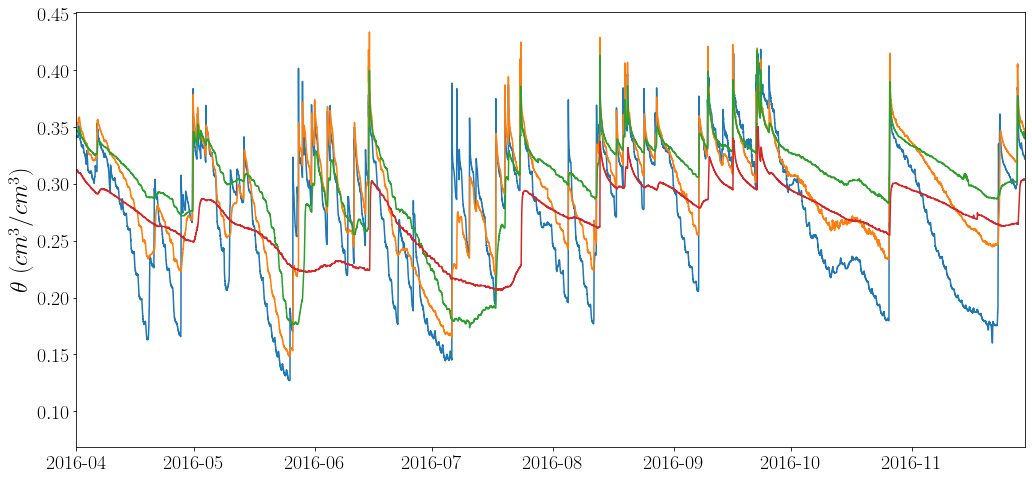

In [11]:
sm_data = pd.read_csv('/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/gages/data/IFC/2016/Otter3.csv')
sm_data['dt'] = pd.to_datetime(sm_data['dt'])
fig,ax = plt.subplots(figsize=(17, 8))
ax.plot(sm_data['dt'],sm_data['sm_5'], label='5 cm')
ax.plot(sm_data['dt'],sm_data['sm_10'], label='10 cm')
ax.plot(sm_data['dt'],sm_data['sm_20'], label='20 cm')
ax.plot(sm_data['dt'],sm_data['sm_50'],label='50 cm')
ax.tick_params(labelsize = 20)
ax.set_xlim([datetime(2016,4,1), datetime(2016, 11,30)])
# ax1.tick_params(labelsize = 20)
ax.set_ylabel(r'$\theta \ (cm^3/cm^3)$', fontsize = 24)

## Monte Carlo simulations on monthly basis with hourly rainfall
Initial soil moisture $\theta_i$ is assumed to be variable at the beginning of the simulations. 
- 100 simulations with initial soil moisture conditions from 0.05 to 1 in normalized soil moisture
- three time period are considered in here: 
    - Before vegetation growth season
    - During vegetation growth season
    - After vegetation is full developed

In [172]:
from functions.check_model import sm_model_time_based,sm_model
import datetime
stages = [4, 5, 6]
run_sets = dict()
run_sets[1] = dict()
run_sets[1]['et_p'] = 3.1
run_sets[1]['theta_i'] = 246
run_sets[1]['theta_wp'] = 74
run_sets[1]['theta_star'] = 143.1 # Field Capacity
run_sets[1]['theta_s'] = 246
run_sets[1]['yaron_c'] = 0.022
run_sets[1]['color'] = 'blue'
tscale = 'H'
results = dict()
div_fac = {'30min':24*2, 'H':24, 'D':1}
div_fac1 = {'30min':24, 'H':24, 'D':1}
for stage in stages:
    results[stage] = dict()
    for init in np.arange(50, run_sets[1]['theta_s'], 5):
        results[stage][init] = dict()  
        res_p = []
        data_p = []
        for year in range(2001,2021):
            data_forcing = []
            idx = (p_data['GPM']['H']['timestamps']>pd.Timestamp(datetime.date(year,stage,1))) & (p_data['GPM']['H']['timestamps']<pd.Timestamp(datetime.date(year,stage,1) + datetime.timedelta(days=35)))
            filtered = p_data['GPM']['H'].loc[idx]
            for i, p in enumerate(filtered['rain'].values):
                if p>0:
                    data_forcing.append((i, 1, p*div_fac[tscale], filtered['timestamps'].iloc[i]))
                    # data_forcing.append((i, 1, p, p_data['GPM'][tscale]['timestamps'].loc[i]))
                else:
                    data_forcing.append((i, 0, 0, filtered['timestamps'].iloc[i]))
            
            et_p = run_sets[1]['et_p']
            theta_i = init
            theta_wp = run_sets[1]['theta_wp']
            theta_star = run_sets[1]['theta_star']
            theta_s = run_sets[1]['theta_s']
            yaron_c = run_sets[1]['yaron_c']
            _res_p, _data_p = sm_model_time_based(data_forcing, theta_i, theta_s, theta_wp, theta_star, et_p/div_fac[tscale], yaron_c, tscale)
            res_p.append(_res_p)
            data_p.append(_data_p)
        results[stage][init]['res_p']  = res_p
        results[stage][init]['p_data'] = data_p

In [173]:
results_all = dict()
for stage in stages:
    results_all[stage] = []
    for init in np.arange(50, run_sets[1]['theta_s'], 5):
        for x in results[stage][init]['res_p']:
            for y in x:
                results_all[stage].append(list(y) + [init])
    results_all[stage] = pd.DataFrame(results_all[stage])

In [17]:
import pickle
with open('/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/sim_test_GPM_hourly.pickle', 'wb') as handle:
    pickle.dump(results_all, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [177]:
mean_sm = dict()
sd_sm = dict()
for stage in [4,5,6]:
    mean_sm[stage] = dict()
    sd_sm[stage] = dict()
    for ds in range(1,5):
        mean_sm[stage][ds] = []
        sd_sm[stage][ds] = []
        for init in np.arange(50, run_sets[1]['theta_s'], 5):
            idx = (results_all[stage][5]==init) & (results_all[stage][3].dt.dayofyear==(152-(6-stage)*30)+ds*8) & (results_all[stage][3].dt.hour==1)

            mean_sm[stage][ds].append((init, np.mean(results_all[stage].loc[idx][1])))
            sd_sm[stage][ds].append((init, np.std(results_all[stage].loc[idx][1])))

        mean_sm[stage][ds] = np.array(mean_sm[stage][ds])
        sd_sm[stage][ds] = np.array(sd_sm[stage][ds])

In [176]:
results_all[stage][3].dt.hour

0          1
1          2
2          3
3          4
4          5
          ..
671195    19
671196    20
671197    21
671198    22
671199    23
Name: 3, Length: 671200, dtype: int64

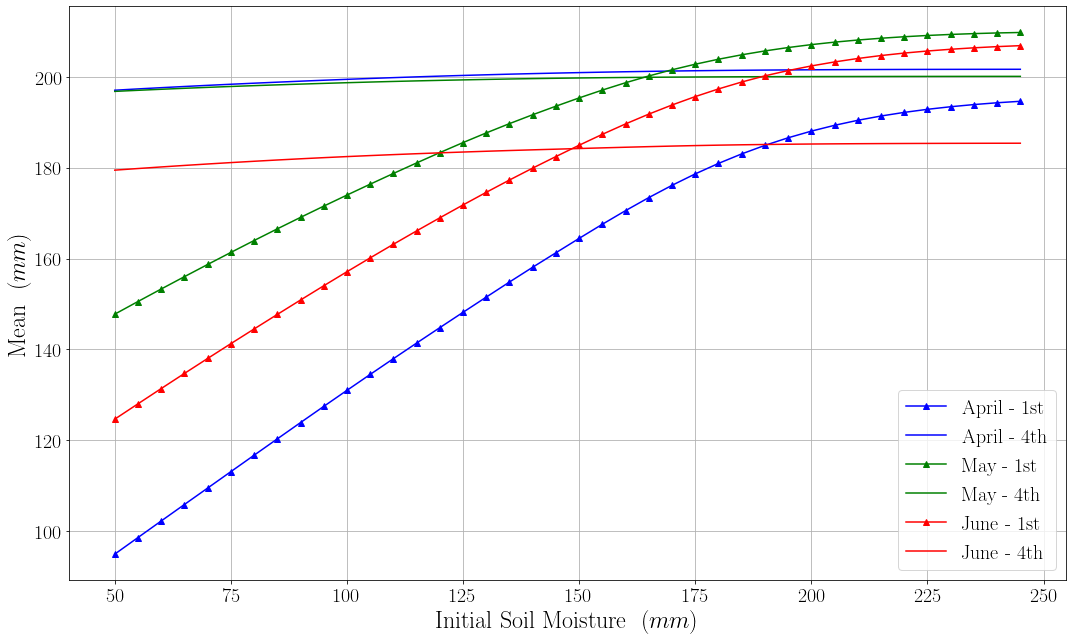

In [180]:
fig,ax = plt.subplots(figsize=(15, 9))
ax.tick_params(labelsize = 20)
ax.set_ylabel(r'Mean \ ($mm$)', fontsize = 24)
ax.set_xlabel(r'Initial Soil Moisture \ ($mm$)', fontsize = 24)
ax.tick_params(labelsize = 20)
plt.plot(mean_sm[4][1][:,0],mean_sm[4][1][:,1], color='blue', marker='^', label = 'April - 1st')
plt.plot(mean_sm[4][4][:,0],mean_sm[4][4][:,1], color='blue', label = 'April - 4th')
plt.plot(mean_sm[5][1][:,0],mean_sm[5][1][:,1], color='g', marker='^',label = 'May - 1st')
plt.plot(mean_sm[5][4][:,0],mean_sm[5][4][:,1], color='g', label = 'May - 4th')
plt.plot(mean_sm[6][1][:,0],mean_sm[6][1][:,1], color='red', marker='^', label = 'June - 1st')
plt.plot(mean_sm[6][4][:,0],mean_sm[6][4][:,1], color='red', label = 'June - 4th')
ax.grid('major')
ax.legend(fontsize=20)
# ax.set_ylim([0,])
fig.tight_layout()
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/mean_sm_hourly.jpg', dpi=300)

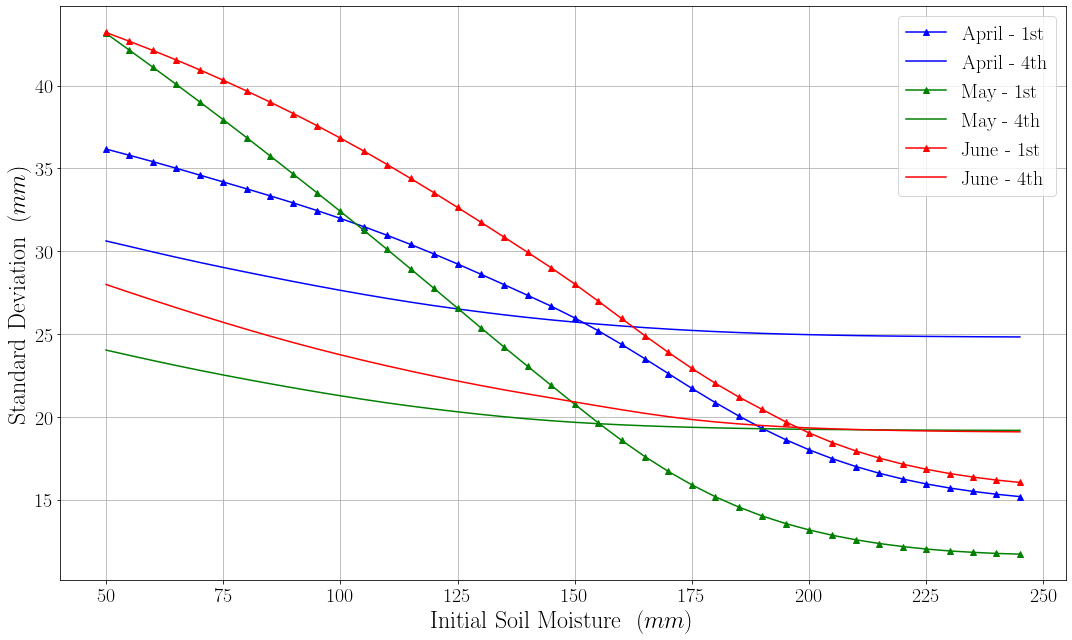

In [181]:

fig,ax = plt.subplots(figsize=(15, 9))
ax.tick_params(labelsize = 20)
ax.set_ylabel(r'Standard Deviation \ ($mm$)', fontsize = 24)
ax.set_xlabel(r'Initial Soil Moisture \ ($mm$)', fontsize = 24)
ax.tick_params(labelsize = 20)
plt.plot(sd_sm[4][1][:,0],sd_sm[4][1][:,1], color='blue', marker='^', label = 'April - 8 days')
plt.plot(sd_sm[4][4][:,0],sd_sm[4][4][:,1], color='blue', label = 'April - 32 days')
plt.plot(sd_sm[5][1][:,0],sd_sm[5][1][:,1], color='g', marker='^',label = 'May - 8 days')
plt.plot(sd_sm[5][4][:,0],sd_sm[5][4][:,1], color='g', label = 'May - 32 days')
plt.plot(sd_sm[6][1][:,0],sd_sm[6][1][:,1], color='red', marker='^', label = 'June - 8 days')
plt.plot(sd_sm[6][4][:,0],sd_sm[6][4][:,1], color='red', label = 'June - 32 days')
ax.grid('major')
ax.legend(fontsize=20)
fig.tight_layout()
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/sd_sm_hourly.jpg', dpi=300)

## Monte Carlo simulations on monthly basis with hourly rainfall and event-based
Initial soil moisture $\theta_i$ is assumed to be variable at the beginning of the simulations. 
- simulations with initial soil moisture conditions from Permanent Wilting Point to Saturation
- simulations  
- three time period are considered in here: 
    - Before vegetation growth season (April)
    - During vegetation growth season (May)
    - During vegetation is full developed (June)

### Preprocess rainfall from hourly to event-based rainfall time-series

In [2]:
from functions.event_detector import storm_def
import datetime

mit_list = [9]
tscale= 'H'
p_events = dict()
for prod in ['GPM']:
    _prod = prod_list[prod]
    dt_col = _prod['dt_col']
    p_col = _prod['p_col']
    p_events[prod] = dict()    
    for tscale in ['H']:
        data = p_data[prod][tscale]
        mit_dry = []
        # events = dict()
        # dry_periods = dict()
        # storm_arrivals = dict()
        # p_events[prod][tscale] = dict()
        for mit in mit_list:
            events = storm_def(data, mit)
            dry_periods = [(events['start'][i+1] - events['end'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
            storm_arrivals = [(events['start'][i+1] - events['start'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
            mit_dry.append((mit, np.std(dry_periods)/ np.mean(dry_periods),np.std(storm_arrivals)/ np.mean(storm_arrivals), 
            np.mean(dry_periods), np.mean(storm_arrivals)))
        p_events[prod][tscale] = np.array(mit_dry)

In [3]:
p_new = []
for event in events.itertuples():
    for n in range(int(event.deltat)):
        p_new.append((event.start+datetime.timedelta(hours=n), event.precip))
p_new = pd.DataFrame(p_new, columns=['timestamps','rain'])
p_new = p_new.set_index('timestamps')
dates = pd.date_range('2000/06/01', '2020/12/31', freq='H')
dates.name = 'timestamps'
p_new = p_new.reindex(dates).fillna(0)
p_new = p_new.reset_index()

In [4]:
from functions.check_model import sm_model_time_based,sm_model
run_sets = dict()
run_sets[1] = dict()
run_sets[2] = dict()
run_sets[3] = dict()
run_sets[1]['et_p'] = 3.1
run_sets[1]['theta_i'] = 246
run_sets[1]['theta_wp'] = 74
run_sets[1]['theta_star'] = 143.1 # Field Capacity
run_sets[1]['theta_s'] = 246
run_sets[1]['yaron_c'] = 0.022
run_sets[1]['color'] = 'blue'


run_sets[2]['et_p'] = 6.3
run_sets[2]['theta_i'] = 574
run_sets[2]['theta_wp'] = 173
run_sets[2]['theta_star'] = 330 # Field Capacity
run_sets[2]['theta_s'] = 574
run_sets[2]['yaron_c'] = 0.022
run_sets[2]['color'] = 'red'

run_sets[3]['et_p'] = 4.6
run_sets[3]['theta_i'] = 574
run_sets[3]['theta_wp'] = 173
run_sets[3]['theta_star'] = 330 # Field Capacity
run_sets[3]['theta_s'] = 574
run_sets[3]['yaron_c'] = 0.014
run_sets[3]['color'] = 'green'

results_pevents = dict()
div_fac = {'30min':24*2, 'H':24, 'D':1}
div_fac1 = {'30min':24, 'H':24, 'D':1}
tscale='H'
data_forcing = []

for i, p in enumerate(p_new['rain']):
    if p>0.5:
        data_forcing.append((i, 1, p*div_fac[tscale], p_new['timestamps'].loc[i]))
        # data_forcing.append((i, 1, p, p_data['GPM'][tscale]['timestamps'].loc[i]))
    else:
        data_forcing.append((i, 0, 0, p_new['timestamps'].loc[i]))
for i in range(1,4):
    results_pevents[i] = dict()
    et_p = run_sets[i]['et_p']
    theta_i = run_sets[i]['theta_i']
    theta_wp = run_sets[i]['theta_wp']
    theta_star = run_sets[i]['theta_star']
    theta_s = run_sets[i]['theta_s']
    yaron_c = run_sets[i]['yaron_c']
    
    results_pevents[i]['res_p'], results_pevents[i]['data_p'] = sm_model_time_based(data_forcing, theta_i, theta_s, theta_wp, theta_star, et_p/div_fac[tscale], yaron_c, tscale)
        # results[tscale][i]['res_p'], results[tscale][i]['data_p'] = sm_model(data_forcing, theta_i, theta_s, theta_wp, theta_star, et_p, yaron_c)

KeyboardInterrupt: 

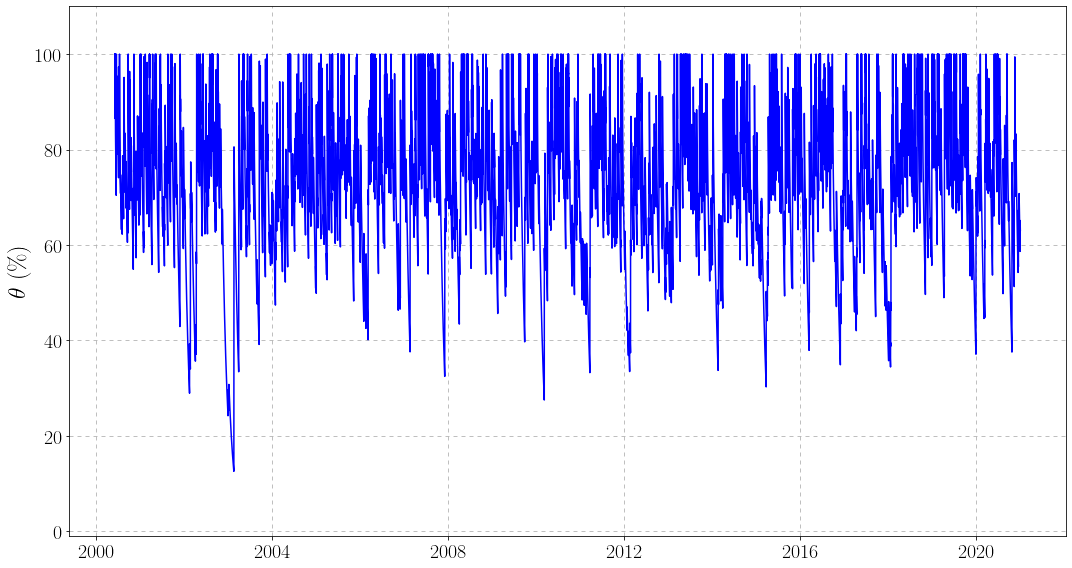

In [7]:
import matplotlib
from datetime import datetime
# load the xfrac package
# matplotlib.rcParams["text.latex.preamble"] = r'\usepackage[dvips]{graphicx}\usepackage{xfrac}'

# xlimits = [(0,)]
fig,ax = plt.subplots(figsize=(15, 8))
# ax1 = ax.twinx()
# ax1.plot(precip_data['dt'], precip_data['precipitationCal'], color='blue', alpha=0.5)
tscale = 'H'
# res_p, data_p = sm_model(data, theta_i, theta_s, theta_star, et_p, yaron_c)
for i in range(1,2):
    ax.plot(results_pevents[i]['res_p'][:,3], (results_pevents[i]['res_p'][:,1]/run_sets[i]['theta_s'])*100, color=run_sets[i]['color'], label=i*'I')
    # ax.annotate(i*'I', xy=(results_et[i]['res_p'][-30, 0] , results_et[i]['res_p'][-30, 1]/run_sets[i]['theta_s'] ),xytext=(results_et[i]['res_p'][-20, 0], results_et[i]['res_p'][-18, 1]/run_sets[i]['theta_s']+0.1*results_et[i]['res_p'][-10, 1]/run_sets[i]['theta_s']),transform=ax.transAxes,
    #         fontsize=20,rotation=-10 )

ax.set_ylim([-1,110])
# xlimits = [0, 70]
# ax.set_xlim([datetime(2015,1,1), datetime(2016, 6,30)])
# ax1.set_xlim(xlimits)
# ax.set_ylim([0,.4])
plt.grid(True, which='major', axis='both', linestyle = (0, (5, 5)))
ax.tick_params(labelsize = 20)
# ax1.tick_params(labelsize = 20)
ax.set_ylabel(r'$\theta \ (\%)$', fontsize = 24)
# ax1.set_ylabel(r'P (mm)', fontsize = 24)
# ax.set_xlabel(r'Time (days)', fontsize = 24)
# ax.legend(fontsize=20,loc='lower right')
fig.tight_layout()
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/model_sm_eventbased_growth_periodI.jpg', dpi=300)

In [5]:
from functions.check_model import sm_model_time_based,sm_model
import datetime
stages = [4, 5, 6]
run_sets = dict()
run_sets[1] = dict()
run_sets[1]['et_p'] = 3.1
run_sets[1]['theta_i'] = 246
run_sets[1]['theta_wp'] = 74
run_sets[1]['theta_star'] = 143.1 # Field Capacity
run_sets[1]['theta_s'] = 246
run_sets[1]['yaron_c'] = 0.022
run_sets[1]['color'] = 'blue'
tscale = 'H'
results_pevents_mc = dict()
div_fac = {'30min':24*2, 'H':24, 'D':1}
div_fac1 = {'30min':24, 'H':24, 'D':1}
for stage in stages:
    results_pevents_mc[stage] = dict()
    for init in np.arange(50, run_sets[1]['theta_s'], 5):
        results_pevents_mc[stage][init] = dict()  
        res_p = []
        data_p = []
        for year in range(2001,2021):
            data_forcing = []
            idx = (p_new['timestamps']>pd.Timestamp(datetime.date(year,stage,1))) & (p_new['timestamps']<pd.Timestamp(datetime.date(year,stage,1) + datetime.timedelta(days=35)))
            filtered = p_new.loc[idx]
            for i, p in enumerate(filtered['rain'].values):
                if p>0.5:
                    data_forcing.append((i, 1, p*div_fac[tscale], filtered['timestamps'].iloc[i]))
                    # data_forcing.append((i, 1, p, p_data['GPM'][tscale]['timestamps'].loc[i]))
                else:
                    data_forcing.append((i, 0, 0, filtered['timestamps'].iloc[i]))
            
            et_p = run_sets[1]['et_p']
            theta_i = init
            theta_wp = run_sets[1]['theta_wp']
            theta_star = run_sets[1]['theta_star']
            theta_s = run_sets[1]['theta_s']
            yaron_c = run_sets[1]['yaron_c']
            _res_p, _data_p = sm_model_time_based(data_forcing, theta_i, theta_s, theta_wp, theta_star, et_p/div_fac[tscale], yaron_c, tscale)
            res_p.append(_res_p)
            data_p.append(_data_p)
        results_pevents_mc[stage][init]['res_p']  = res_p
        results_pevents_mc[stage][init]['p_data'] = data_p

In [6]:
results_all_eventbased = dict()
for stage in stages:
    results_all_eventbased[stage] = []
    for init in np.arange(50, run_sets[1]['theta_s'], 5):
        for x in results_pevents_mc[stage][init]['res_p']:
            for y in x:
                results_all_eventbased[stage].append(list(y) + [init])
    results_all_eventbased[stage] = pd.DataFrame(results_all_eventbased[stage])

In [324]:
import pickle
with open('/mnt/d/ubuntu/projects/gatechProjects/StochSM/data/sim_test_GPM_hourly_eventbased.pickle', 'wb') as handle:
    pickle.dump(results_all_eventbased, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [8]:
mean_sm = dict()
sd_sm = dict()
for stage in [4,5,6]:
    mean_sm[stage] = dict()
    sd_sm[stage] = dict()
    for ds in range(1,5):
        mean_sm[stage][ds] = []
        sd_sm[stage][ds] = []
        for init in np.arange(50, run_sets[1]['theta_s'], 5):
            idx = (results_all_eventbased[stage][5]==init) & (results_all_eventbased[stage][3].dt.dayofyear==(152-(6-stage)*30)+ds*8) & (results_all_eventbased[stage][3].dt.hour==1)

            mean_sm[stage][ds].append((init, np.mean(results_all_eventbased[stage].loc[idx][1])))
            sd_sm[stage][ds].append((init, np.std(results_all_eventbased[stage].loc[idx][1])))

        mean_sm[stage][ds] = np.array(mean_sm[stage][ds])
        sd_sm[stage][ds] = np.array(sd_sm[stage][ds])

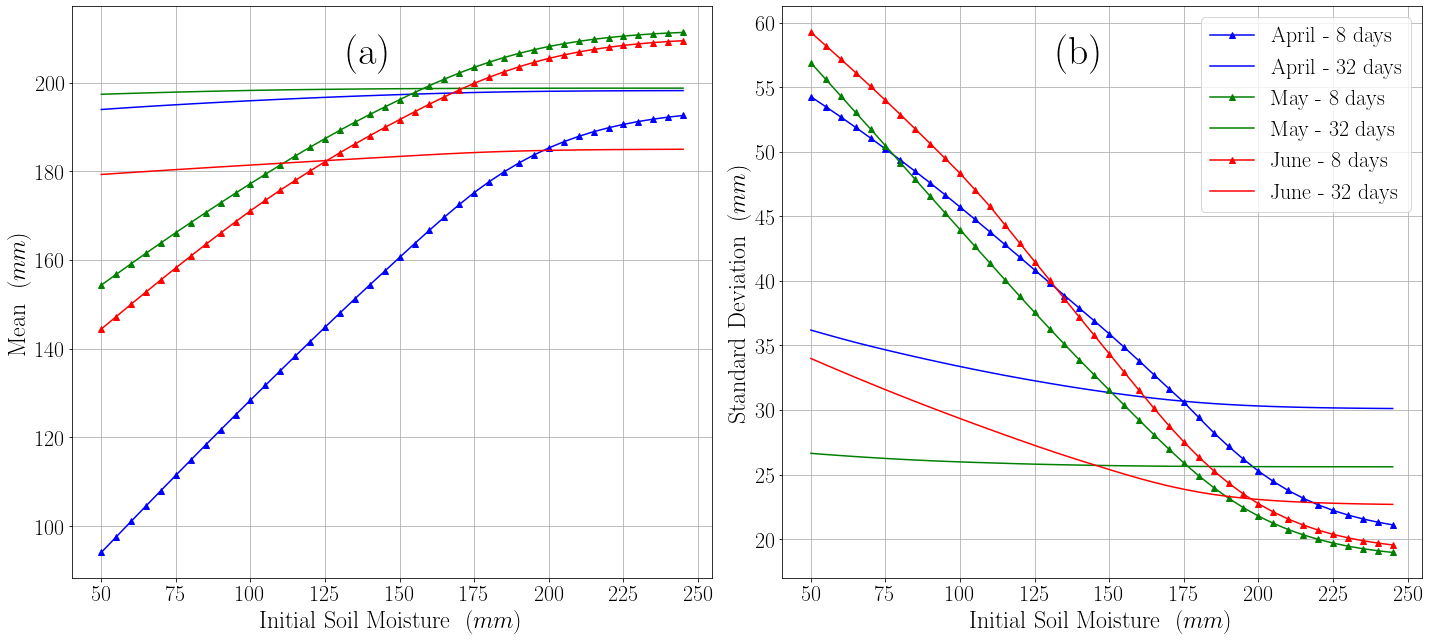

In [22]:
fig,ax = plt.subplots(1,2,figsize=(20, 9))
ax[0].tick_params(labelsize = 22)
ax[0].set_ylabel(r'Mean \ ($mm$)', fontsize = 24)
ax[0].set_xlabel(r'Initial Soil Moisture \ ($mm$)', fontsize = 24)
ax[0].tick_params(labelsize = 22)
ax[0].plot(mean_sm[4][1][:,0],mean_sm[4][1][:,1], color='blue', marker='^', label = 'April - 1st')
ax[0].plot(mean_sm[4][4][:,0],mean_sm[4][4][:,1], color='blue', label = 'April - 4th')
ax[0].plot(mean_sm[5][1][:,0],mean_sm[5][1][:,1], color='g', marker='^',label = 'May - 1st')
ax[0].plot(mean_sm[5][4][:,0],mean_sm[5][4][:,1], color='g', label = 'May - 4th')
ax[0].plot(mean_sm[6][1][:,0],mean_sm[6][1][:,1], color='red', marker='^', label = 'June - 1st')
ax[0].plot(mean_sm[6][4][:,0],mean_sm[6][4][:,1], color='red', label = 'June - 4th')
ax[0].grid('major')


# ax[0].legend(fontsize=20)
# # ax.set_ylim([0,])
# fig.tight_layout()
# fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/mean_sm_hourly_eventbased.jpg', dpi=300)
# fig,ax = plt.subplots(figsize=(15, 9))
ax[1].tick_params(labelsize = 22)
ax[1].set_ylabel(r'Standard Deviation \ ($mm$)', fontsize = 24)
ax[1].set_xlabel(r'Initial Soil Moisture \ ($mm$)', fontsize = 24)

ax[1].plot(sd_sm[4][1][:,0],sd_sm[4][1][:,1], color='blue', marker='^', label = 'April - 8 days')
ax[1].plot(sd_sm[4][4][:,0],sd_sm[4][4][:,1], color='blue', label = 'April - 32 days')
ax[1].plot(sd_sm[5][1][:,0],sd_sm[5][1][:,1], color='g', marker='^',label = 'May - 8 days')
ax[1].plot(sd_sm[5][4][:,0],sd_sm[5][4][:,1], color='g', label = 'May - 32 days')
ax[1].plot(sd_sm[6][1][:,0],sd_sm[6][1][:,1], color='red', marker='^', label = 'June - 8 days')
ax[1].plot(sd_sm[6][4][:,0],sd_sm[6][4][:,1], color='red', label = 'June - 32 days')
ax[1].grid('major')
ax[1].legend(fontsize=22)
fig.tight_layout()
ax[0].text(0.43, 0.9,'(a)',transform=ax[0].transAxes, fontsize = 40, fontweight='bold')
ax[1].text(0.43, 0.9,'(b)',transform=ax[1].transAxes, fontsize = 40, fontweight='bold')
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/mean_sd_sm_hourly_eventbased.jpg', dpi=300)

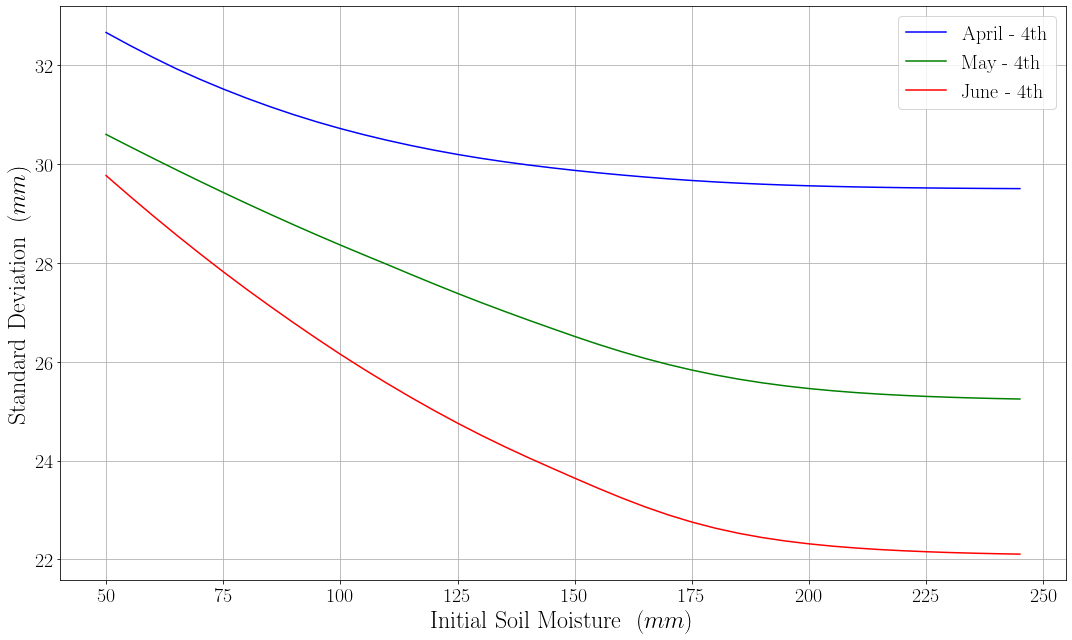

In [268]:
fig,ax = plt.subplots(figsize=(15, 9))
ax.tick_params(labelsize = 20)
ax.set_ylabel(r'Standard Deviation \ ($mm$)', fontsize = 24)
ax.set_xlabel(r'Initial Soil Moisture \ ($mm$)', fontsize = 24)
ax.tick_params(labelsize = 20)
# plt.plot(sd_sm[4][1][:,0],sd_sm[4][1][:,1], color='blue', marker='^', label = 'April - 1st')
plt.plot(sd_sm[4][4][:,0],sd_sm[4][4][:,1], color='blue', label = 'April - 4th')
# plt.plot(sd_sm[5][1][:,0],sd_sm[5][1][:,1], color='g', marker='^',label = 'May - 1st')
plt.plot(sd_sm[5][4][:,0],sd_sm[5][4][:,1], color='g', label = 'May - 4th')
# plt.plot(sd_sm[6][1][:,0],sd_sm[6][1][:,1], color='red', marker='^', label = 'June - 1st')
plt.plot(sd_sm[6][4][:,0],sd_sm[6][4][:,1], color='red', label = 'June - 4th')
ax.grid('major')
ax.legend(fontsize=20)
fig.tight_layout()

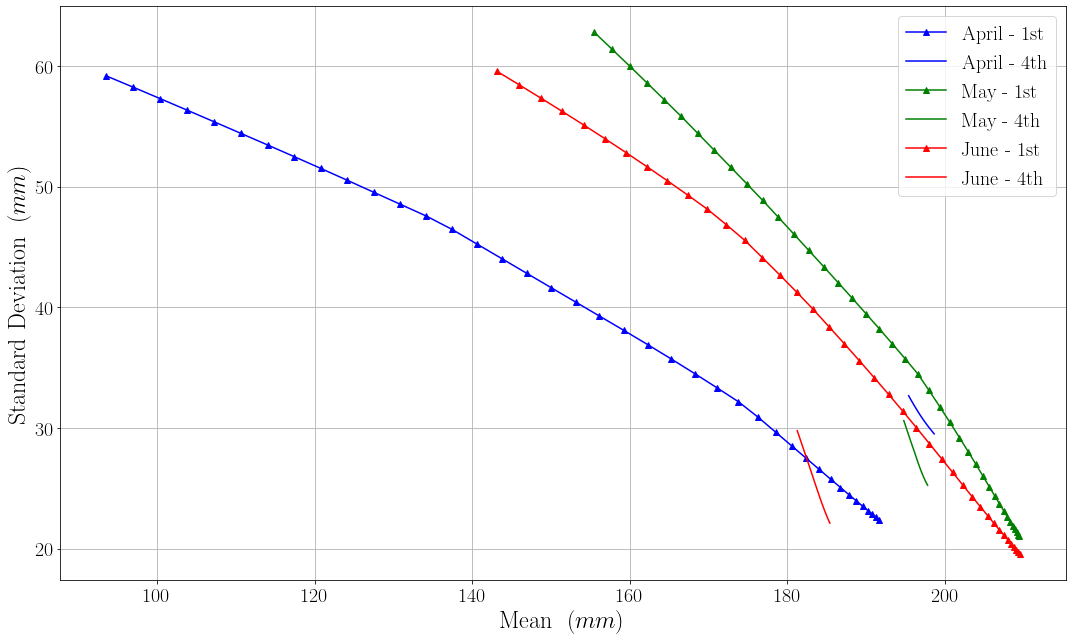

In [269]:
fig,ax = plt.subplots(figsize=(15, 9))
ax.tick_params(labelsize = 20)
ax.set_ylabel(r'Standard Deviation \ ($mm$)', fontsize = 24)
ax.set_xlabel(r'Mean \ ($mm$)', fontsize = 24)
ax.tick_params(labelsize = 20)
plt.plot(mean_sm[4][1][:,1],sd_sm[4][1][:,1], color='blue', marker='^', label = 'April - 1st')
plt.plot(mean_sm[4][4][:,1],sd_sm[4][4][:,1], color='blue', label = 'April - 4th')
plt.plot(mean_sm[5][1][:,1],sd_sm[5][1][:,1], color='g', marker='^',label = 'May - 1st')
plt.plot(mean_sm[5][4][:,1],sd_sm[5][4][:,1], color='g', label = 'May - 4th')
plt.plot(mean_sm[6][1][:,1],sd_sm[6][1][:,1], color='red', marker='^', label = 'June - 1st')
plt.plot(mean_sm[6][4][:,1],sd_sm[6][4][:,1], color='red', label = 'June - 4th')
ax.grid('major')
ax.legend(fontsize=20)
# ax.set_ylim([0,])
fig.tight_layout()
fig.savefig('/mnt/d/ubuntu/projects/gatechProjects/StochSM/figures/initial_results/mean_vs_sd_sm_hourly_eventbased.jpg', dpi=300)


In [272]:
from functions.event_detector import storm_def
import datetime
mit_list = [x for x in range(9,11, 1)]
mit_list = [9]

mean_tb = dict()
p_events = dict()
for prod in ['GPM']:
    _prod = prod_list[prod]
    dt_col = _prod['dt_col']
    p_col = _prod['p_col']
    p_events[prod] = dict()    
    tscale = 'H'
    data = p_data[prod][tscale]
    mit_dry = []
    # events = dict()
    # dry_periods = dict()
    # storm_arrivals = dict()
    # p_events[prod][tscale] = dict()
    mit = 9
    events = storm_def(data, mit)
    dry_periods = [(events['start'][i+1] - events['end'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
    storm_arrivals = [(events['start'][i+1] - events['start'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
    mit_dry.append((mit, np.std(dry_periods)/ np.mean(dry_periods),np.std(storm_arrivals)/ np.mean(storm_arrivals), 
    np.mean(dry_periods), np.mean(storm_arrivals)))
    p_events[prod][tscale] = np.array(mit_dry)
    dry_periods = np.array(dry_periods)
    storm_arrivals = np.array(storm_arrivals)
    mean_tb[prod] = np.array([(m, np.mean(dry_periods[list(events['start'][0:-1].dt.month==m)])) for m in range(1,13)])

In [274]:
events['depth'] = events['precip'] * events['deltat']

In [278]:
storm_stats = dict()
for stage in [4,5,6]:
    storm_stats[stage] = dict()
    idx =(events['start'].dt.dayofyear<(152-(6-stage)*30)+32) & (events['start'].dt.dayofyear>(152-(6-stage)*30))
    filtered = events.loc[idx]
    storm_stats[stage]['mean_h'] = np.mean(filtered['depth'])
    storm_stats[stage]['sd_h'] = np.std(filtered['depth'])
    storm_stats[stage]['mean_i'] = np.mean(filtered['precip'])
    storm_stats[stage]['sd_i'] = np.std(filtered['precip'])
    storm_stats[stage]['mean_tr'] = np.mean(filtered['deltat'])
    storm_stats[stage]['sd_tr'] = np.std(filtered['deltat'])
    
# storm_stats[stage]['N'] = np.mean(len(filtered['depth']))

In [296]:

for stage in [4,5,6]:
    N_events = []
    for year in range(2001,2021):
    
        # idx =(events['start'].dt.dayofyear<(152-(6-stage)*30)+32) & (events['start'].dt.dayofyear>(152-(6-stage)*30))
        idx = (events['start']>pd.Timestamp(datetime.date(year,stage,1))) & (events['start']<pd.Timestamp(datetime.date(year,stage,1) + datetime.timedelta(days=35)))
        filtered = events.loc[idx]
        N_events.append((year, len(filtered['depth'])))
    storm_stats[stage]['N'] = np.mean(np.array(N_events)[:,1])

In [331]:

dry_periods = [(events['start'][i+1] - events['end'][i]).total_seconds()/3600.0 for i in range(len(events)-1)]
dry_periods = np.array(dry_periods)
mean_tb = np.array([(m, np.mean(dry_periods[list(events['start'][0:-1].dt.month==m)])) for m in range(1,13)])


In [333]:
mean_tb[:,1] = mean_tb[:,1]/24

In [ ]:
mean_tb